# ASSUMPTIONS
1) Fill ratio of 100%
2) 1 day granularity
3) No bid-ask spread
4) No volume
5) Stocks are infinitely divisible
6) No latency in order requests - an order is executed a day after having computed the signal to avoid look-back
7) Ignoring market impact
8) Source of the data is an average of different exchanges

In [2]:
import pandas as pd
import numpy as np
import itertools
import datetime
import matplotlib.pyplot as plt
import math
import statsmodels as sm

import yfinance as yf
from mpl_finance import candlestick_ohlc
import matplotlib.dates as mpl_dates
import seaborn as sns

from sklearn.linear_model import LinearRegression
from statsmodels.regression.rolling import RollingOLS
from statsmodels.regression.linear_model import OLS
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from scipy.optimize import curve_fit, minimize
from scipy.stats import norm
from pykalman import KalmanFilter

def cagr(returns, resolution):
   return np.prod(1+returns)**(resolution/len(returns))-1

def mdd(returns):
  cum_rets = (1 + returns).cumprod()
  max_cumret = cum_rets.cummax()
  drawdown = 1 - cum_rets / max_cumret
  return np.max(drawdown)

def sharpe(returns, riskfreerate = 0, resolution = 252):
  try:
    sharpe = np.sqrt(resolution) * (np.mean(returns) - riskfreerate/resolution) / (np.std(returns))
  except ZeroDivisionError:
    sharpe = 0.0
    
  return sharpe

# SETTING THE START AND END DATES
coint_start_date = '2015-01-01'
coint_end_date = '2018-01-01'
start_date = '2018-01-01'
end_date = '2020-01-01'


/var/folders/9g/rsnwbnjs00l3g2dxtn8xpmr00000gn/T/ipykernel_58576/2699783752.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
/Users/francescofiorani/doc/Capitox_pairs_trading/capitox3.10/lib/python3.10/site-packages/mpl_finance.py:16: DeprecationWarning: 



    Please use `mplfinance` instead (no hyphen, no underscore).

    To install: `pip install --upgrade mplfinance` 

   For more information, see: https://pypi.org/project/mplfinance/


  __warnings.warn('\n\n  ================================================================='+


In [3]:
import warnings
warnings.filterwarnings("ignore")

# Let us now find a set of securities which are cointegrated. Our set of strategies rely on this assumption so it is important that the pair of stocks we pick show this trait.
We will first look at the pearson correlation coefficient of a set of different stocks over a set period. Over the same period, we run a cointegration test to determine which pairs are integrated. Our assumption is that pairs that were cointegrated over the test period will remain cointegrated over the period were the strategy is running.

In [4]:
symbols = ['GDX','GDXJ','GLD', 'AAPL','GOOGL', 'META','AMD',
           'NVDA','CSCO', 'ORCL', 'TTWO', 'EA', 'HYG',
           'LQD', 'JNK', 'SLV', 'USLV', 'SIVR', 'USO', 'UWT',
           'QQQ', 'SPY', 'VOO', 'VDE', 'VTI', 'EMLP', 'VDC',
           'FSTA', 'KXI', 'IBB', 'VHT','VNQ', 'IYR', 'MSFT',
           'PG', 'TMF', 'UPRO', 'WFC', 'JPM', 'GS', 'CVX',
           'XOM', 'INTC', 'COST', 'WMT', 'T', 'VZ', 'CMCSA', 'AMZN']

coint_prices = yf.download(symbols, start=coint_start_date, end=coint_end_date)['Adj Close']
prices = yf.download(symbols, start=start_date, end=end_date)['Adj Close']

# Remove tickers with less than 10 years of data
coint_prices = coint_prices.dropna(axis=1)
prices = prices.dropna(axis=1)

prices.head(10)


[*********************100%%**********************]  49 of 49 completed
[*********************100%%**********************]  49 of 49 completed


Ticker,AAPL,AMD,AMZN,CMCSA,COST,CSCO,CVX,EA,EMLP,FSTA,...,VDC,VDE,VHT,VNQ,VOO,VTI,VZ,WFC,WMT,XOM
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,40.670982,10.98,59.450500,35.741459,170.348938,32.156815,97.522392,107.341278,19.454357,29.352520,...,124.616989,80.004288,142.921829,65.712471,222.653702,124.984650,39.031979,50.917606,29.541073,62.638470
2018-01-03,40.663898,11.55,60.209999,35.167088,172.393265,32.413342,98.233276,107.635521,19.564404,29.352520,...,124.488358,81.219498,144.341324,65.521690,223.978333,125.708061,38.229900,51.309338,29.798765,63.868713
2018-01-04,40.852772,12.12,60.479500,35.393345,171.054504,32.505047,97.927498,105.124840,19.587988,29.438593,...,124.891403,81.656326,144.377960,64.392967,224.960556,126.187279,38.353855,51.951130,29.825727,63.957081
2018-01-05,41.317890,11.88,61.457001,35.715355,169.833344,32.955227,97.766998,110.224655,19.501518,29.550499,...,125.311577,81.632507,145.513565,64.424782,226.402298,126.928795,38.266354,52.301193,30.002520,63.905537
2018-01-08,41.164440,12.28,62.343498,35.228016,170.493652,33.297028,98.248550,111.038658,19.572264,29.619354,...,125.688904,82.093178,144.817581,64.758621,226.870895,127.218132,38.200737,51.709419,30.445980,64.192825
2018-01-09,41.159702,11.82,62.634998,35.341137,168.512634,33.088608,97.721138,110.018700,19.470085,29.576323,...,125.508797,81.910484,146.612534,63.924007,227.348434,127.453239,38.060623,51.892792,30.080427,63.920254
2018-01-10,41.150261,11.96,62.716499,35.758858,167.725677,33.272026,98.347946,110.087341,19.297152,29.429989,...,124.728447,81.783424,146.438568,63.208603,226.960983,127.254280,38.119606,52.609581,29.864683,63.411980
2018-01-11,41.384003,12.14,63.834000,37.072952,171.307800,33.430408,101.336754,109.842163,19.438637,29.421379,...,124.771324,83.483116,147.189514,62.993992,228.637070,128.330338,38.429344,52.517891,29.969559,64.038124
2018-01-12,41.811348,12.02,65.260002,36.933716,173.533035,34.072353,102.124084,110.950386,19.477938,29.369734,...,124.754166,84.182022,148.215225,62.485252,230.150864,129.080841,38.244984,52.134499,30.224243,64.472755


We now have only 43 tickers left.

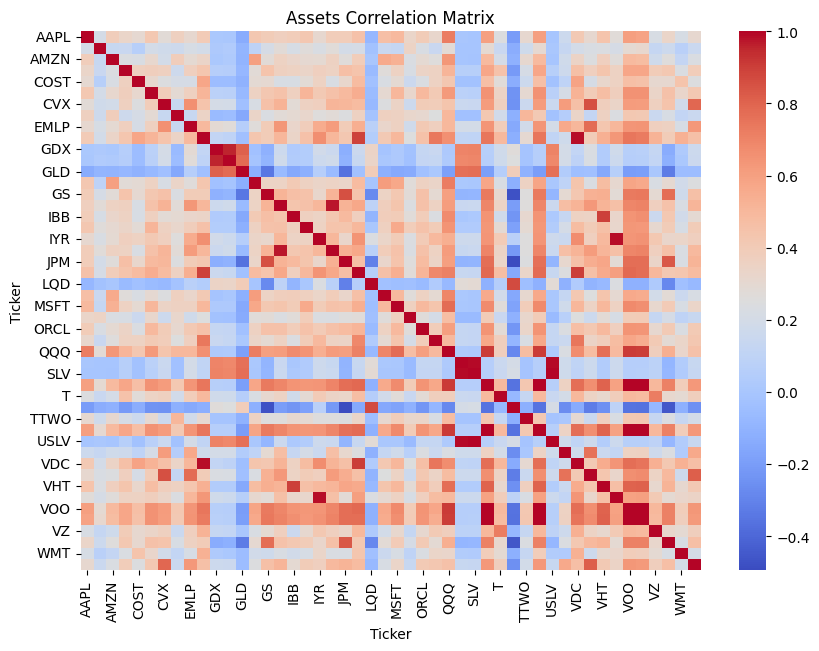

In [5]:
# Update the symbols list
symbols = prices.columns
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(coint_prices.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('./images/Pearson_Correlation_Matrix', dpi=300)

## Let us now look at the value of cointegration between price series

In [6]:
def find_cointegrated_pairs(prices):
    """
    Takes a dataframe of prices and returns a matrix of p-values from the cointegration test and the pairs of assets that are cointegrated, that is, have a p-value less than 0.05
    
    @param prices: DataFrame of prices to test for cointegration. Each column should be a price series.
    
    @return pvalue_matrix, pairs: 1) pvalue_matrix: DataFrame of p-values from the cointegration test for each pair of series
                                    2) pairs: list of triples. The first two entries are the tickers of the cointegrated stocks and the third entry is the p-value of the cointegration test. Sorted by p-value.
    """
    
    n = prices.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = prices.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(prices[keys[i]], prices[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j], result[1]))
    pairs = sorted(pairs, key=lambda x: x[2])
    return pvalue_matrix, pairs

# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(coint_prices)
print(pairs)


[('IYR', 'LQD', 6.96150546514876e-06), ('GDX', 'XOM', 0.0017772607966500098), ('LQD', 'VNQ', 0.0018568319526554714), ('AMD', 'CMCSA', 0.004034314904520014), ('IYR', 'PG', 0.004816542961162105), ('GDXJ', 'XOM', 0.012933900061688368), ('SIVR', 'XOM', 0.013606628364098216), ('SLV', 'VZ', 0.014167339457433963), ('SLV', 'XOM', 0.014312542122521275), ('SIVR', 'VZ', 0.014907271573922472), ('ORCL', 'VHT', 0.016276665180695652), ('NVDA', 'VOO', 0.020399242463779003), ('NVDA', 'SPY', 0.020703646723709355), ('GLD', 'XOM', 0.02135608204953438), ('PG', 'VNQ', 0.024648387217351388), ('AMZN', 'GOOGL', 0.02482347887663201), ('COST', 'MSFT', 0.025520441698791488), ('FSTA', 'PG', 0.030698426884902895), ('NVDA', 'QQQ', 0.03154264778703301), ('GDX', 'SIVR', 0.031634018405396105), ('COST', 'INTC', 0.03177105661115824), ('VZ', 'XOM', 0.032835803705130596), ('GDX', 'VZ', 0.03317010978545379), ('COST', 'CSCO', 0.03465409511086759), ('AMZN', 'MSFT', 0.0357419417810579), ('IYR', 'VDC', 0.03587183772309817), ('F

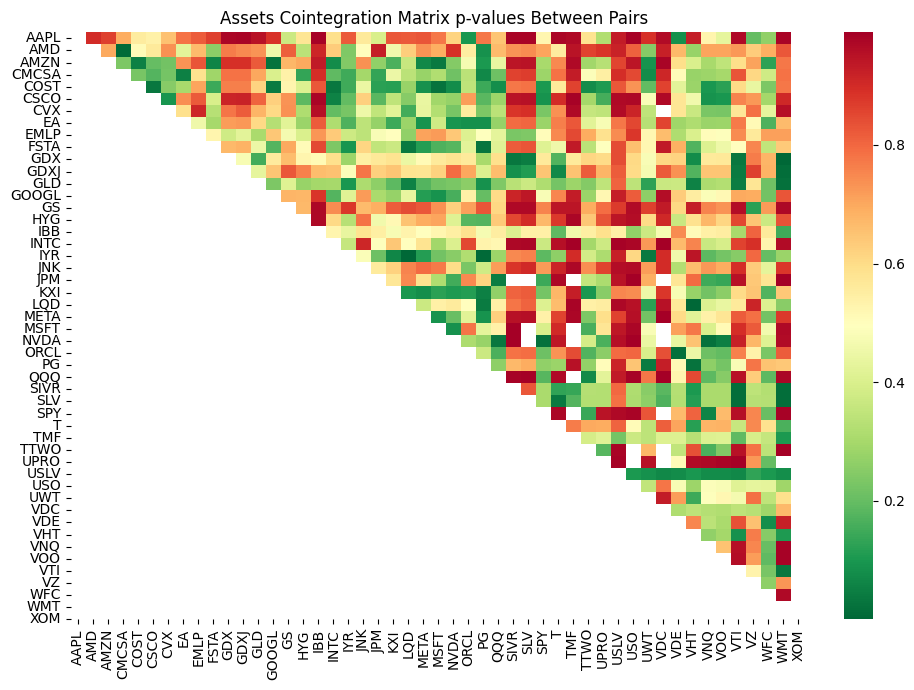

In [7]:
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = prices.columns,
                yticklabels = prices.columns, cmap = 'RdYlGn_r',
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('./images/Cointegration_matrix', dpi=300)

# Now that we have our prices and cointegrated pairs, let's compare a few strategies.

Since all our strategies will be based on a zscore, let us first define the helper function below that allows us to compute our positions given a zscore dataset.

In [8]:
def create_positions_from_zscore(zscore, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    Given the zscore time series, generate the corresponding trading positions
    
    @param zscore: the zscore time series
    @param long_threshold: the zscore value at which a long position is entered
    @param short_threshold: the zscore value at which a short position is entered
    @param exit_long_threshold: the zscore value at which a long position is closed
    @param exit_short_threshold: the zscore value at which a short position is closed
    
    @return: pd.Series containing the trading positions, 1 for long, -1 for short, 0 for neutral
    """
    
    # creating the long series
    longs = pd.Series(index=zscore.index, data=np.nan, dtype=bool)
    entry_longs = zscore < long_threshold
    cannot_be_long = zscore > exit_long_threshold
    longs[entry_longs] = True
    longs[cannot_be_long] = False
    longs.iloc[0] = False
    longs.ffill(inplace=True)
    
    # creating the short series
    shorts = pd.Series(index=zscore.index, data=np.nan, dtype=bool)
    entry_shorts = zscore > short_threshold
    cannot_be_short = zscore < exit_short_threshold
    shorts[entry_shorts] = True
    shorts[cannot_be_short] = False
    shorts.iloc[0] = False
    shorts.ffill(inplace=True)
    
    # creating the positions series
    positions = pd.Series(index = zscore.index, data = np.where(longs, 1, np.where(shorts, -1, 0)))

    
    return positions
    

## Let me define the strategies we will be testing.

In [9]:
def vanilla_strategy(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal.  It returns the name of the strategy - used for plotting - and a DataFrame
    containing the positions, the spread, and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    
    name = 'Vanilla strategy'
    # Calculate the spread
    spreads = prices[pair[0]] - prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.rolling(window).mean()
    spread_std = spreads.rolling(window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals


# perhaps there a better way to do this
def exponential_moving_average_strategy(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0): 
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the positions, the spread, and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    
    name = 'Exponential Moving Average strategy'
    # Calculate the spread
    spreads = prices[pair[0]] - prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.ewm(span=window).mean()
    spread_std = spreads.ewm(span=window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals


def basic_linear_regression_strategy(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the positions, the spread, and
    the z-score. 
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period in days for the moving average and standard deviation
    entry_threshold : float containing the z-score value for the entry signal
    exit_threshold : float containing the z-score value for the exit signal
    """
    
    name = 'Basic Linear Regression strategy'
    # Calculate the spread
    # the issue with this is that we are using information from the future
    model = OLS(prices[pair[0]], add_constant(prices[pair[1]])).fit()
    hedge_ratio = model.params[1]
    spreads = prices[pair[0]] - hedge_ratio * prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.rolling(window).mean()
    spread_std = spreads.rolling(window).std()
    
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals


def linear_regression_strategy(prices, pair, period = 10, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, and
    the z-score. The running time could be improved by using a rolling regression.
    Can the performance be improved by combining with a Kalman filter?
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    period : int containing the lookback period in days for the linear regression
    window : int containing the lookback period in days for the moving average and standard deviation
    entry_threshold : float containing the z-score value for the entry signal
    exit_threshold : float containing the z-score value for the exit signal
    """
    
    name = 'Linear Regression strategy'
    # Calculate the spread
    spread = pd.Series(index=prices.index)
        
    for i in range(period, len(prices)):
        past_price_1 = prices[pair[0]].iloc[i - period:i]
        past_price_2 = prices[pair[1]].iloc[i - period:i]

        model = OLS(past_price_1, add_constant(past_price_2)).fit()

        spread.iloc[i] = prices[pair[0]].iloc[i] - model.predict([1, prices[pair[1]].iloc[i]])[0]
        

    # Calculate the rolling mean and standard deviation
    spread_ma = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    
    # Calculate the z-score
    zscore = (spread - spread_ma) / spread_std
    
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spread, 'zscore': zscore})
    return name, signals

# the following strategy uses the beta computed from the linear regression to determine the percentage of the portfolio to allocate to each asset
def linear_regression_strategy_with_hedge_ratios(prices, pair, period = 10, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    period : int containing the lookback period in days for the linear regression
    window : int containing the lookback period in days for the moving average and standard deviation
    entry_threshold : float containing the z-score value for the entry signal
    exit_threshold : float containing the z-score value for the exit signal
    """
    
    name = 'Linear Regression strategy with Hedge Ratios'
    # Calculate the spread
    spread = pd.Series(index=prices.index)
    hedge_ratios = pd.Series(index=prices.index)
        
    for i in range(period, len(prices)):
        past_price_1 = prices[pair[0]].iloc[i - period:i]
        past_price_2 = prices[pair[1]].iloc[i - period:i]

        model = OLS(past_price_1, add_constant(past_price_2)).fit()
        hedge_ratios.iloc[i] = model.params.iloc[1]

        spread.iloc[i] = prices[pair[0]].iloc[i] - model.predict([1, prices[pair[1]].iloc[i]])[0]
        

    # Calculate the rolling mean and standard deviation
    spread_ma = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    
    # Calculate the z-score
    zscore = (spread - spread_ma) / spread_std
    
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spread, 'hedge_ratios': hedge_ratios, 'zscore': zscore})
    return name, signals



def linear_regression_strategy_only_hedge_ratios(prices, pair, period = 10, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    period : int containing the lookback period in days for the linear regression
    window : int containing the lookback period in days for the moving average and standard deviation
    entry_threshold : float containing the z-score value for the entry signal
    exit_threshold : float containing the z-score value for the exit signal
    """
    
    name = 'Linear Regression strategy with Only Hedge Ratios'
    # Calculate the spread
    spread = pd.Series(index=prices.index)
    hedge_ratios = pd.Series(index=prices.index)
        
    for i in range(period, len(prices)):
        past_price_1 = prices[pair[0]].iloc[i - period:i]
        past_price_2 = prices[pair[1]].iloc[i - period:i]

        model = OLS(past_price_1, add_constant(past_price_2)).fit()
        hedge_ratios.iloc[i] = model.params.iloc[1]

        spread.iloc[i] = prices[pair[0]].iloc[i] - prices[pair[1]].iloc[i] * hedge_ratios.iloc[i]
        

    # Calculate the rolling mean and standard deviation
    spread_ma = spread.rolling(window).mean()
    spread_std = spread.rolling(window).std()
    
    # Calculate the z-score
    zscore = (spread - spread_ma) / spread_std
    
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spread, 'hedge_ratios': hedge_ratios, 'zscore': zscore})
    return name, signals

def buy_and_hold_strategy(prices, pair, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple buy and hold strategy. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    """
    
    name = 'Buy and Hold strategy'
    # Getting the positions
    positions = pd.Series(index = prices.index, data = 1)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': prices[pair[0]] - prices[pair[1]], 'zscore': 0})
    return name, signals

## Implementing the Kalman Filter strategy.

The strategy starts by denoising both price series individually, then regresses one time series with the other to obtain an adapting hedge ratio. This hedge ratio is used to both compute the zscore and to 
determine the portfolio needed to buy or sell by the strategy.

In [10]:

def KalmanFilterAverage(x):
  # Construct a Kalman filter
    kf = KalmanFilter(transition_matrices = [1],
    observation_matrices = [1],
    initial_state_mean = 0,
    initial_state_covariance = 1,
    observation_covariance=1,
    transition_covariance=.01)
  # Use the observed values of the price to get a rolling mean
    state_means, _ = kf.filter(x.values)
    state_means = pd.Series(state_means.flatten(), index=x.index)
    return state_means


# Kalman filter regression
def KalmanFilterRegression(x,y):
    delta = 1e-3
    trans_cov = delta / (1 - delta) * np.eye(2) # How much random walk wiggles
    obs_mat = np.expand_dims(np.vstack([[x], [np.ones(len(x))]]).T, axis=1)
    kf = KalmanFilter(n_dim_obs=1, n_dim_state=2, # y is 1-dimensional, (alpha, beta) is 2-dimensional
    initial_state_mean=[0,0],
    initial_state_covariance=np.ones((2, 2)),
    transition_matrices=np.eye(2),
    observation_matrices=obs_mat,
    observation_covariance=2,
    transition_covariance=trans_cov)
    # Use the observations y to get running estimates and errors for the state parameters
    state_means, state_covs = kf.filter(y.values)
    return state_means


def kalman_strategy_without_hedge_ratios(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    name = "Kalman strategy without Hedge Ratios"
    # Calculate the spread 
    state_means = KalmanFilterRegression(KalmanFilterAverage(prices[pair[0]]), KalmanFilterAverage(prices[pair[1]]))
    hedge_ratios = state_means[:,0]
    spreads = prices[pair[0]] - hedge_ratios * prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.rolling(window).mean()
    spread_std = spreads.rolling(window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    # # Adjust the spread for the hedge ratio
    # spreads /= prices[pair[0]] + hedge_ratios * prices[pair[1]]
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals


def kalman_strategy_with_hedge_ratios(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    name = "Kalman strategy with Hedge Ratios"
    # Calculate the spread 
    state_means = KalmanFilterRegression(KalmanFilterAverage(prices[pair[0]]), KalmanFilterAverage(prices[pair[1]]))
    hedge_ratios = state_means[:,0]
    spreads = prices[pair[0]] - hedge_ratios * prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.rolling(window).mean()
    spread_std = spreads.rolling(window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    # # Adjust the spread for the hedge ratio
    # spreads /= prices[pair[0]] + hedge_ratios * prices[pair[1]]
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'hedge_ratios': hedge_ratios, 'zscore': zscore})
    return name, signals

## Running a few experiments we noticed that the kalman strategy and the exponential strategy both have low MDD and high sharpe ratios. Therefore, we combine the two strategies here and hope to decrease the MDD even further.

In [11]:

def exponential_kalman(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    name = "Exponential Kalman strategy"
    # Calculate the spread 
    state_means = KalmanFilterRegression(KalmanFilterAverage(prices[pair[0]]), KalmanFilterAverage(prices[pair[1]]))
    hedge_ratios = state_means[:,0]
    spreads = prices[pair[0]] - hedge_ratios * prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.ewm(window).mean()
    spread_std = spreads.ewm(window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    # # Adjust the spread for the hedge ratio
    # spreads /= prices[pair[0]] + hedge_ratios * prices[pair[1]]
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals

def exponential_kalman_strategy_with_hedge_ratios(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    name = "Exponential Kalman strategy with Hedge Ratios"
    # Calculate the spread 
    state_means = KalmanFilterRegression(KalmanFilterAverage(prices[pair[0]]), KalmanFilterAverage(prices[pair[1]]))
    hedge_ratios = state_means[:,0]
    spreads = prices[pair[0]] - hedge_ratios * prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.ewm(window).mean()
    spread_std = spreads.ewm(window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    # # Adjust the spread for the hedge ratio
    # spreads /= prices[pair[0]] + hedge_ratios * prices[pair[1]]
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'hedge_ratios': hedge_ratios, 'zscore': zscore})
    return name, signals



## Lastly, let us implement a few strategies that use the half life computed over the cointegration period to determine the rolling z-score window

In [23]:
def half_life(spread):
    spread_lag = spread.shift(1)
    spread_lag.iloc[0] = spread_lag.iloc[1]
    spread_ret = spread - spread_lag
    spread_ret.iloc[0] = spread_ret.iloc[1]
    model = OLS(spread_ret, add_constant(spread_lag))
    res = model.fit()
    halflife = int(round(-np.log(2) / res.params.iloc[1],0))
    if halflife <= 0:
        halflife = 1
    return halflife

half_lives = {(pair[0], pair[1]): half_life(coint_prices[pair[0]] - coint_prices[pair[1]]) for pair in pairs}

def vanilla_half_life_strategy(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal.  It returns the name of the strategy - used for plotting - and a DataFrame
    containing the positions, the spread, and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    
    name = 'Vanilla half-life strategy'
    # Calculate the spread
    spreads = prices[pair[0]] - prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.rolling(half_lives[pair]).mean()
    spread_std = spreads.rolling(window).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals

def kalman_half_life_strategy(prices, pair, window = 20, long_threshold = -1, short_threshold = 1, exit_long_threshold = 0, exit_short_threshold = 0):
    """
    This function implements a simple mean-reversion strategy
    using the z-score as a signal. It returns It returns the name of the strategy - used for plotting - and a DataFrame
    containing the long, short, and exit signals, the spread, the hedge ratios and
    the z-score.
    
    prices : DataFrame containing the price prices
    pair : tuple containing the ticker symbols of the pair
    window : int containing the lookback period for the moving average and standard deviation
    long_threshold : float containing the z-score value for the long signal
    short_threshold : float containing the z-score value for the short signal
    exit_long_threshold : float containing the z-score value for the long exit signal
    exit_short_threshold : float containing the z-score value for the short exit signal
    """
    name = "Kalman half life strategy"
    # Calculate the spread 
    state_means = KalmanFilterRegression(KalmanFilterAverage(prices[pair[0]]), KalmanFilterAverage(prices[pair[1]]))
    hedge_ratios = state_means[:,0]
    spreads = prices[pair[0]] - hedge_ratios * prices[pair[1]]
    # Calculate the rolling mean and standard deviation
    spread_ma = spreads.rolling(half_lives[pair]).mean()
    spread_std = spreads.rolling(half_lives[pair]).std()
    # Calculate the z-score
    zscore = (spreads - spread_ma) / spread_std
    # Getting the positions
    positions = create_positions_from_zscore(zscore, long_threshold, short_threshold, exit_long_threshold, exit_short_threshold)
    # # Adjust the spread for the hedge ratio
    # spreads /= prices[pair[0]] + hedge_ratios * prices[pair[1]]
    # Combine the signals
    signals = pd.DataFrame({'positions': positions, 'spread': spreads, 'zscore': zscore})
    return name, signals

# Let us now backtest our strategies

In [24]:
def plot_signals(prices, signals, pair, returns, name):
    """
    This function plots the price prices and the signals.
    
    prices : DataFrame containing the price prices
    signals : DataFrame containing the signals
    pair : tuple containing the ticker symbols of the pair
    strategy : string containing the name of the strategy
    """
    
    # compute the entry and exists from the positions
    positions = signals['positions']
    entry_longs = (positions.shift(1) != 1) & (positions == 1)
    entry_shorts = (positions.shift(1) != -1) & (positions == -1)
    exits_to_neutral = (positions.shift(1) != 0) & (positions == 0)
    exits_to_neutral.iloc[0] = False

    # Create the figure and the first subplot
    fig, ax = plt.subplots(4, 1, figsize=(15, 8), sharex=True)
    
    # Set the overall title for the plots
    fig.suptitle(f'Trading strategy: {name}', fontsize=16)
        

    # Plot the price prices
    ax[0].plot(prices[pair[0]], label=pair[0])
    ax[0].plot(prices[pair[1]], label=pair[1])
    ax[0].set_title('Price Data')
    ax[0].legend()
    # Plot the spread and the signals
    ax[1].plot(signals['spread'], label='Spread')
    ax[1].axhline(signals['spread'].mean(), c='black', linestyle='--', label='Mean')
    ax[1].fill_between(signals.index, -2, 2, color='gray', alpha=0.3)
    ax[1].plot(signals.loc[entry_longs].index, signals['spread'][entry_longs], '^', markersize=5, color='g', label='Long')
    ax[1].plot(signals.loc[entry_shorts].index, signals['spread'][entry_shorts], 'v', markersize=5, color='r', label='Short')
    ax[1].plot(signals.loc[exits_to_neutral].index, signals['spread'][exits_to_neutral], 'o', markersize=3, color='k', label='Exit')
    ax[1].set_title('Spread and Signals')
    ax[1].legend()
    # Plot the returns
    ax[2].plot((1 + returns).cumprod(), label='Returns')
    ax[2].set_title('Cumulative Returns')

    # Create a new figure for Sharpe Ratio, CAGR, and MDD

    ax[3].text(0.28, 0.9, f'Sharpe Ratio: {sharpe(returns):.2f}', transform=ax[3].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax[3].text(0.46, 0.9, f'CAGR: {cagr(returns, 255)*100:.2f}%', transform=ax[3].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    ax[3].text(0.61, 0.9, f'MDD: {mdd(returns):.2%}', transform=ax[3].transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

    ax[3].axis('off')  # Hide axes

    plt.savefig('./images/' + name + '_' + pair[0] + '_' + pair[1] + '_metrics', dpi=300)
    plt.show()



def simple_backtest(prices, pair, signals, transaction_cost=0.0):
    """
    This function implements a simple backtest and returns a DataFrame
    
    @param signals: DataFrame containing the trading signals, return function of the strategy
    @param transaction_cost: float containing the transaction cost as a fixed fee
    
    @return: pd.Series containing the returns of the strategy
    """
    
    # Retrieve the positions and shift them by one period to prevent look-ahead bias
    positions = signals['positions'].shift(1)
    
    # compute the entry and exists from the positions for the fixed transaction cost
    changes = (positions != positions.shift(1))
    changes.iloc[0] = False
    
    # Retrieve the hedge ratios, if they are present
    try:
        hedge_ratios = signals['hedge_ratios']
    except KeyError:
        hedge_ratios = None
        
    # Compute the percentage of the portfolio to allocate to each stock
    first_stock_returns = prices[pair[0]].pct_change()
    second_stock_returns = prices[pair[1]].pct_change()
    returns = 0
    if (hedge_ratios is not None):
        # assert((hedge_ratios >= 0).all())
        pct_first_stock = 1 / (1 + abs(hedge_ratios))
        pct_second_stock = 1 - pct_first_stock
        returns = (pct_first_stock * positions * first_stock_returns) - (pct_second_stock * positions * second_stock_returns)
        
    else: # if we don't have the hedge ratios, we assume that we are equally allocating the portfolio, which is 1.0
        returns = 0.5 * positions * (first_stock_returns - second_stock_returns)
    
    # Should the transaction cost be an absolute fee or a percentage of the trade? Right now they are a an absolute fee
    returns -= (changes.sum()) * transaction_cost
    
    return returns

We now backtest our different strategies on the pair of stocks selected and print out the results. 

In [ ]:
strategies = [vanilla_strategy, exponential_moving_average_strategy, linear_regression_strategy, linear_regression_strategy_with_hedge_ratios,
              kalman_strategy_without_hedge_ratios, kalman_strategy_with_hedge_ratios, buy_and_hold_strategy, kalman_half_life_strategy, vanilla_half_life_strategy, 
              exponential_kalman_strategy_with_hedge_ratios, exponential_kalman, linear_regression_strategy_only_hedge_ratios]

performance_cols = ['Pair', 'strategy', 'CAGR', 'MDD', 'Sharpe', 'total_return']
performance = []
for i in range(len(pairs)):
    security1, security2, _ = pairs[i]
    for strategy in strategies:
        # Create the signals
        name, signals = strategy(prices, (security1, security2), long_threshold = -1.25, short_threshold = 1.25, exit_long_threshold = -0.08, exit_short_threshold = 0.08)
        # Backtest the strategy
        returns = simple_backtest(prices, (security1, security2), signals)
        # Plot
        plot_signals(prices, signals, (security1, security2), returns, name)
        # Save the results in the performance DataFrame
        new_performance_row = [
            (security1, security2), 
            name, 
            cagr(returns, 252), 
            mdd(returns),       
            sharpe(returns),
            (1 + returns).cumprod()[-1]
            ]
        
        
        performance.append(new_performance_row)
        
        # Print the results
        print(f'{security1} and {security2}')
        print(f'strategy: {name}')
        #print(f'CAGR: {cagr(returns, 252):.2%}')
        print(f'MDD: {mdd(returns):.2%}')
        print(f'Sharpe: {sharpe(returns)}')
        print('')
        
performance = pd.DataFrame(performance, columns=performance_cols)

In [26]:
performance.head(10)

,Pair,strategy,CAGR,MDD,Sharpe,total_return
0,"(IYR, LQD)",Vanilla strategy,0.041750,0.078221,0.671258,1.085067
1,"(IYR, LQD)",Exponential Moving Average strategy,0.036048,0.076806,0.585599,1.073245
2,"(IYR, LQD)",Linear Regression strategy,-0.013783,0.095189,-0.187893,0.972678
3,"(IYR, LQD)",Linear Regression strategy with Hedge Ratios,-0.008896,0.100233,-0.091922,0.982322
4,"(IYR, LQD)",Kalman strategy without Hedge Ratios,0.028386,0.057175,0.467883,1.057459
5,"(IYR, LQD)",Kalman strategy with Hedge Ratios,0.026272,0.046692,0.505553,1.053126
6,"(IYR, LQD)",Buy and Hold strategy,0.022702,0.067206,0.378341,1.045826
7,"(IYR, LQD)",Kalman half life strategy,0.059190,0.078221,0.929606,1.121627
8,"(IYR, LQD)",Vanilla half-life strategy,0.017970,0.093097,0.316931,1.036190
9,"(IYR, LQD)",Exponential Kalman strategy with Hedge Ratios,0.030067,0.046157,0.575152,1.060914


In [27]:
performance = performance.sort_values(by = 'Sharpe', ascending = False)
performance.head(20)

,Pair,strategy,CAGR,MDD,Sharpe,total_return
158,"(GLD, XOM)",Linear Regression strategy,0.274913,0.092390,2.182682,1.623837
74,"(SIVR, XOM)",Linear Regression strategy,0.304160,0.061323,2.131665,1.699042
98,"(SLV, XOM)",Linear Regression strategy,0.287868,0.061043,2.019585,1.656939
206,"(FSTA, PG)",Linear Regression strategy,0.114157,0.039654,2.002689,1.240814
325,"(SLV, T)",Exponential Moving Average strategy,0.264333,0.083950,1.840282,1.597052
193,"(COST, MSFT)",Exponential Moving Average strategy,0.197862,0.049671,1.768619,1.433846
159,"(GLD, XOM)",Linear Regression strategy with Hedge Ratios,0.188487,0.090466,1.743952,1.411533
50,"(IYR, PG)",Linear Regression strategy,0.141729,0.062579,1.687820,1.302859
324,"(SLV, T)",Vanilla strategy,0.233215,0.096159,1.609389,1.519555
368,"(LQD, PG)",Vanilla half-life strategy,0.139227,0.067584,1.525101,1.297167


In [28]:
performance['strategy'].value_counts()

strategy
Linear Regression strategy                           36
Exponential Moving Average strategy                  36
Linear Regression strategy with Hedge Ratios         36
Vanilla strategy                                     36
Vanilla half-life strategy                           36
Kalman strategy with Hedge Ratios                    36
Buy and Hold strategy                                36
Linear Regression strategy with Only Hedge Ratios    36
Kalman strategy without Hedge Ratios                 36
Exponential Kalman strategy                          36
Kalman half life strategy                            36
Exponential Kalman strategy with Hedge Ratios        36
Name: count, dtype: int64

Text(0.5, 1.0, 'Sharpe Ratio by strategy')

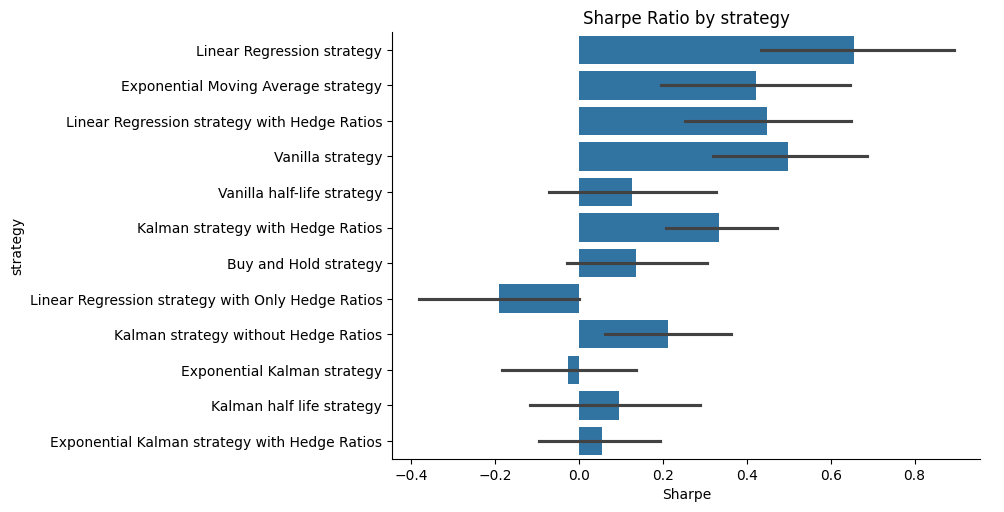

In [29]:
sns.catplot(y = 'strategy', x = 'Sharpe', data = performance, kind = 'bar', aspect = 2)
plt.title('Sharpe Ratio by strategy')

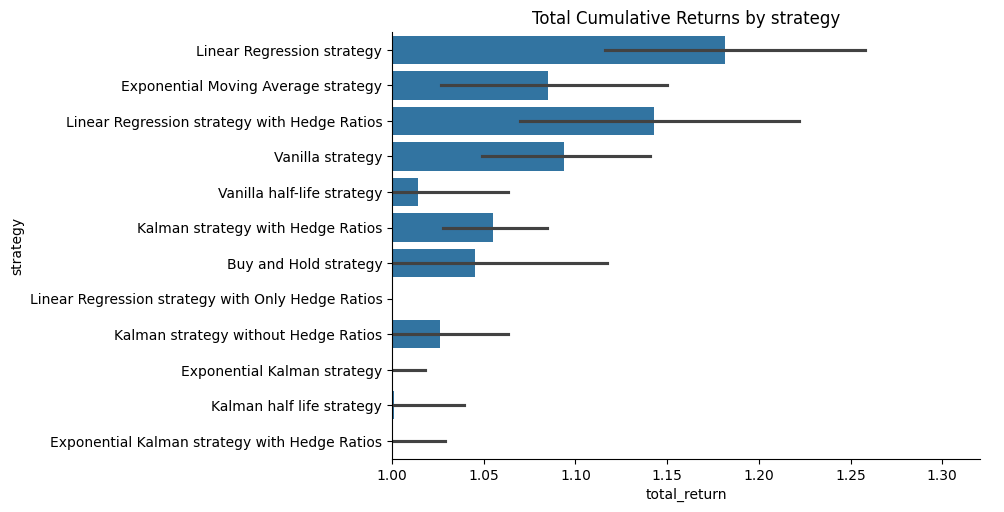

In [30]:
plot = sns.catplot(y = 'strategy', x = 'total_return', data = performance, kind = 'bar', aspect = 2)
plt.title('Total Cumulative Returns by strategy')
plot.set(xlim=(1, None))


Text(0.5, 1.0, 'MDD by strategy')

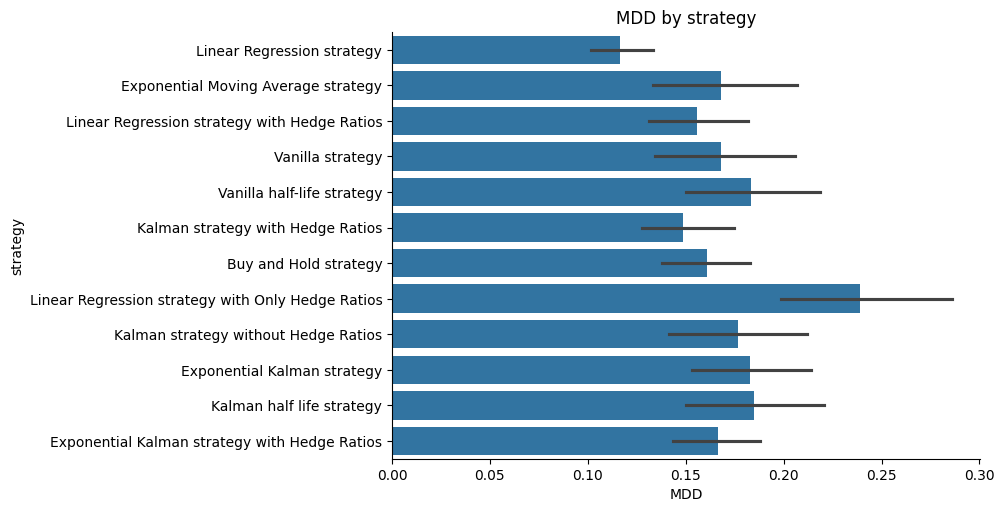

In [31]:
sns.catplot(y = 'strategy', x = 'MDD', data = performance, kind = 'bar', aspect = 2)
plt.title('MDD by strategy')

Text(0.5, 1.0, 'Best Strategies by Pair based on Sharpe Ratio')

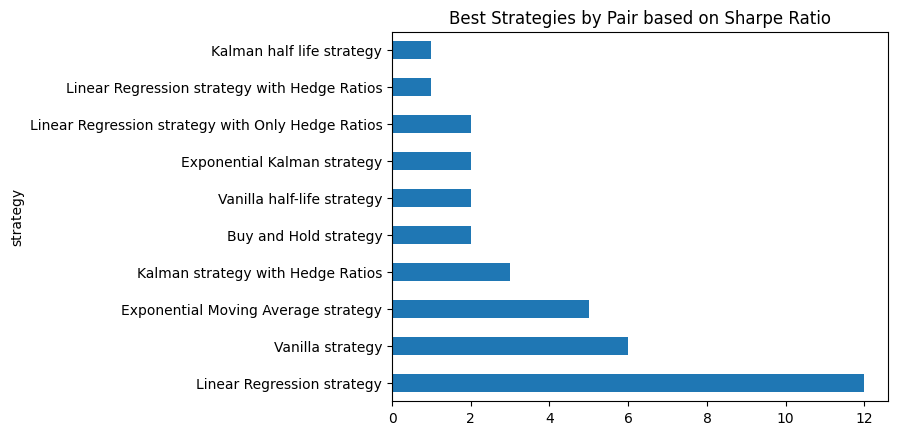

In [32]:
# Find the strategy with the best Sharpe ratio for each pair
best_strategies = performance.loc[performance.groupby('Pair')['Sharpe'].idxmax()]

# Plot the counts of the best strategies
best_strategies['strategy'].value_counts().plot.barh()

plt.title('Best Strategies by Pair based on Sharpe Ratio')


Text(0.5, 1.0, 'Best Strategies by Pair based on total returns')

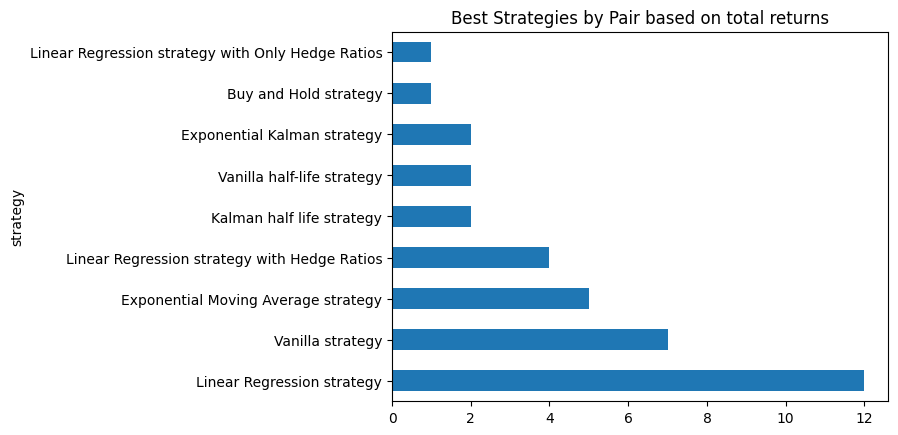

In [33]:
# Find the strategy with the best cumulative returns for each pair
best_strategies = performance.loc[performance.groupby('Pair')['total_return'].idxmax()]

# Plot the counts of the best strategies
best_strategies['strategy'].value_counts().plot.barh()

plt.title('Best Strategies by Pair based on total returns')

Text(0.5, 1.0, 'Best Strategies by Pair based on lowest MDD')

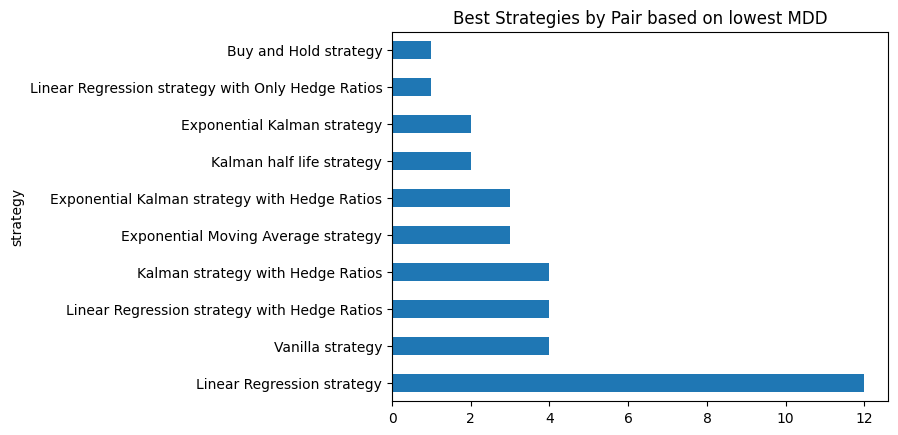

In [34]:
# Find the strategy with the best MDD for each pair
best_strategies = performance.loc[performance.groupby('Pair')['MDD'].idxmin()]

# Plot the counts of the best strategies
best_strategies['strategy'].value_counts().plot.barh()

plt.title('Best Strategies by Pair based on lowest MDD')

## Let us check if rebalancing the portfolio to reflect the difference in prices of the pairs to avoid one of the two stocks lead the returns of the strategies

In [45]:
# this dictionary will contain the percentage of the portfolio to allocate to the first asset of the pair when computing returns
pair_weights = {}

for pair in pairs:
    average_absolute_return0 = coint_prices[pair[0]].pct_change().abs().mean()
    average_absolute_return1 = coint_prices[pair[1]].pct_change().abs().mean()
    pair_weights[(pair[0], pair[1])] = average_absolute_return1 / (average_absolute_return0 + average_absolute_return1)
    

def simple_weighted_backtest(prices, pair, signals, transaction_cost=0.0):
    """
    This function implements a simple backtest and returns a DataFrame
    
    @param signals: DataFrame containing the trading signals, return function of the strategy
    @param transaction_cost: float containing the transaction cost as a fixed fee
    
    @return: pd.Series containing the returns of the strategy
    """
    
    # Retrieve the positions and shift them by one period to prevent look-ahead bias
    positions = signals['positions'].shift(1)
    
    # compute the entry and exists from the positions for the fixed transaction cost
    changes = (positions != positions.shift(1))
    changes.iloc[0] = False
    
    # Retrieve the hedge ratios, if they are present
    try:
        hedge_ratios = signals['hedge_ratios']
    except KeyError:
        hedge_ratios = None
        
    # Compute the percentage of the portfolio to allocate to each stock
    first_stock_returns = prices[pair[0]].pct_change()
    second_stock_returns = prices[pair[1]].pct_change()
    returns = 0
    pct_first_stock = pair_weights[pair]
    if (hedge_ratios is not None):
        pct_first_stock *= 1 / (1 + abs(hedge_ratios))
    
    pct_second_stock = 1 - pct_first_stock
    returns = (pct_first_stock * positions * first_stock_returns) - (pct_second_stock * positions * second_stock_returns)
    
    # Should the transaction cost be an absolute fee or a percentage of the trade? Right now they are a an absolute fee
    returns -= (changes.sum()) * transaction_cost
    
    return returns

In [46]:
performance_cols = ['Pair', 'strategy', 'CAGR', 'MDD', 'Sharpe', 'total_return']
performance = []
for i in range(len(pairs)):
    security1, security2, _ = pairs[i]
    for strategy in strategies:
        # Create the signals
        name, signals = strategy(prices, (security1, security2), long_threshold = -1.25, short_threshold = 1.25, exit_long_threshold = -0.08, exit_short_threshold = 0.08)
        # Backtest the strategy
        returns = simple_weighted_backtest(prices, (security1, security2), signals)

        # Save the results in the performance DataFrame
        new_performance_row = [
            (security1, security2), 
            name, 
            cagr(returns, 252), 
            mdd(returns),       
            sharpe(returns),
            (1 + returns).cumprod()[-1]
            ]
        
        
        performance.append(new_performance_row)
        
performance = pd.DataFrame(performance, columns=performance_cols)

Text(0.5, 1.0, 'Sharpe Ratio by strategy')

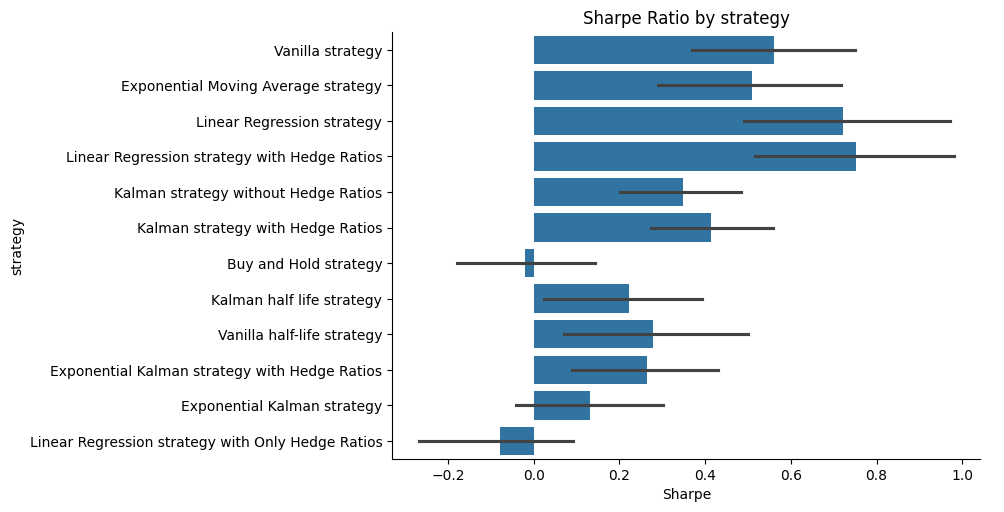

In [47]:
sns.catplot(y = 'strategy', x = 'Sharpe', data = performance, kind = 'bar', aspect = 2)
plt.title('Sharpe Ratio by strategy')

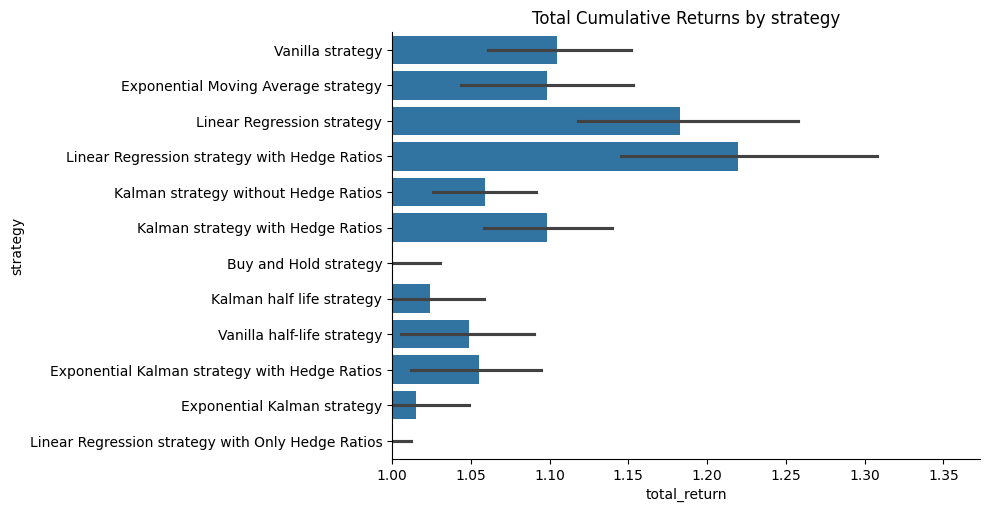

In [48]:
plot = sns.catplot(y = 'strategy', x = 'total_return', data = performance, kind = 'bar', aspect = 2)
plt.title('Total Cumulative Returns by strategy')
plot.set(xlim=(1, None))

Text(0.5, 1.0, 'MDD by strategy')

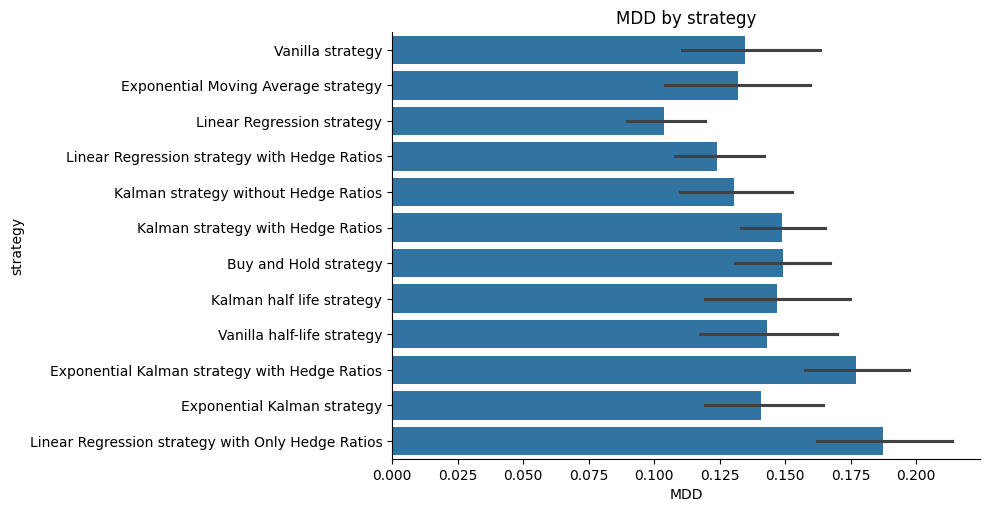

In [49]:
sns.catplot(y = 'strategy', x = 'MDD', data = performance, kind = 'bar', aspect = 2)
plt.title('MDD by strategy')

Text(0.5, 1.0, 'Best Strategies by Pair based on Sharpe Ratio')

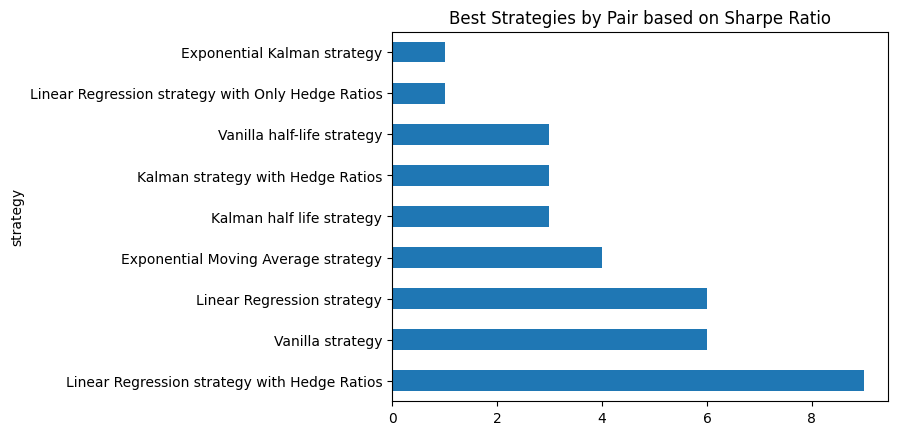

In [50]:
# Find the strategy with the best Sharpe ratio for each pair
best_strategies = performance.loc[performance.groupby('Pair')['Sharpe'].idxmax()]

# Plot the counts of the best strategies
best_strategies['strategy'].value_counts().plot.barh()

plt.title('Best Strategies by Pair based on Sharpe Ratio')

Text(0.5, 1.0, 'Best Strategies by Pair based on total returns')

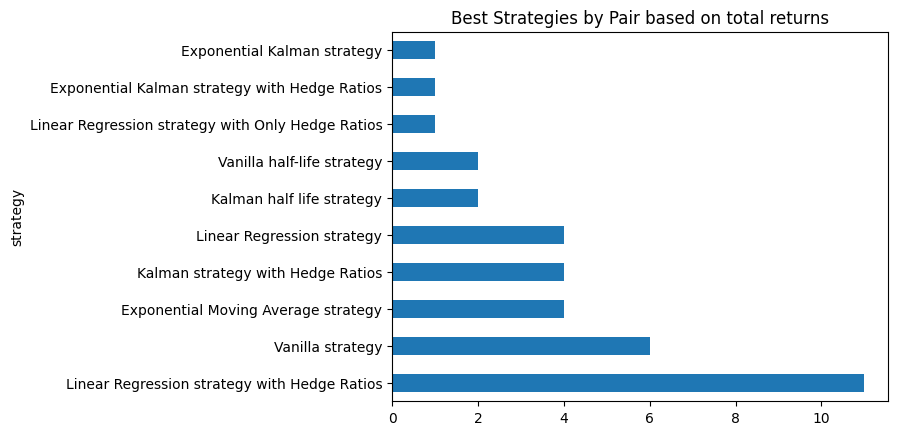

In [51]:
# Find the strategy with the best cumulative returns for each pair
best_strategies = performance.loc[performance.groupby('Pair')['total_return'].idxmax()]

# Plot the counts of the best strategies
best_strategies['strategy'].value_counts().plot.barh()

plt.title('Best Strategies by Pair based on total returns')

Text(0.5, 1.0, 'Best Strategies by Pair based on lowest MDD')

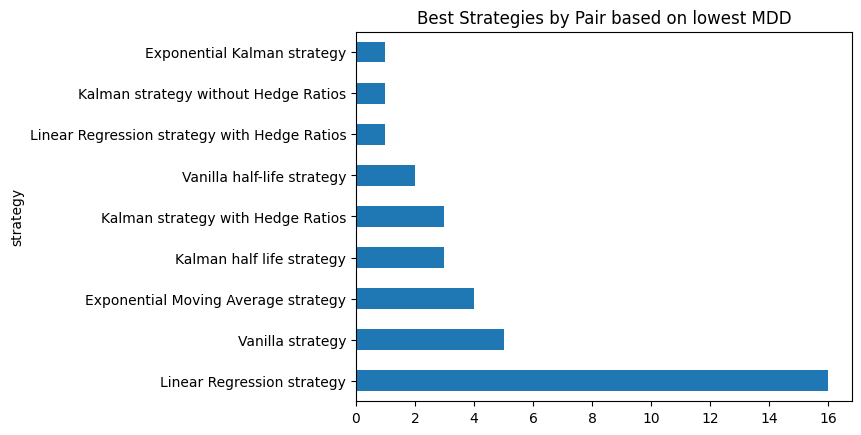

In [52]:
# Find the strategy with the best MDD for each pair
best_strategies = performance.loc[performance.groupby('Pair')['MDD'].idxmin()]

# Plot the counts of the best strategies
best_strategies['strategy'].value_counts().plot.barh()

plt.title('Best Strategies by Pair based on lowest MDD')